# Cloud masks

Different instruments, by virtue of their differing measurement principle and footprint, see clouds in different ways. To provide an overview of the cloud fields sampled by HALO during EUREC⁴A, a cloud mask is created for each cloud sensitive instrument.  
In the following, we compare the different cloud mask products for a case study on 5 February and further provide a statistical overview for the full campaign period.

More information on the dataset can be found in Konow et al. (in preparation). If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

In [1]:
import eurec4a
import numpy as np
import xarray as xr
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

We generally don't support ignoring warnings, however, we do so in this notebook to suppress warnings originating from zero division. Unfortunately, we coudn't find another way to handle the warnings. If you have an idea, please make a pull request and change it :)

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Cloud cover functions
We define some utility functions to extract (circle) cloud cover estimates from different datasets assuming that the datasets follow a certain flag meaning convention.  

In particular, we define a **minimum cloud cover** based on the cloud mask flag `most_likely_cloudy` and a **maximum cloud cover** combining the flags `most_likely_cloudy` and `probably_cloudy`. The cloud mask datasets slightly vary in their flag definition for cloud free conditions and their handling of unvalid measurements which is taken care of by the following functions.

In [3]:
def _isvalid(da):
    meanings = dict(zip(da.flag_meanings.split(" "), da.flag_values))
    return ~(np.isnan(da) | ("unknown" in meanings and da==meanings["unknown"]))

def _cloudy_max(da):
    meanings = dict(zip(da.flag_meanings.split(" "), da.flag_values))
    return (da==meanings["most_likely_cloudy"]) | (da==meanings["probably_cloudy"])

def _cloudy_min(da):
    meanings = dict(zip(da.flag_meanings.split(" "), da.flag_values))
    return da==meanings["most_likely_cloudy"]

def cfmin(ds):
    sumdims = [d for d in ds.cloud_mask.dims if d != "time"]
    return (_cloudy_min(ds.cloud_mask).sum(dim=sumdims)
            / _isvalid(ds.cloud_mask).sum(dim=sumdims))

def cfmax(ds):
    sumdims = [d for d in ds.cloud_mask.dims if d != "time"]
    return (_cloudy_max(ds.cloud_mask).sum(dim=sumdims)
            / _isvalid(ds.cloud_mask).sum(dim=sumdims))

def correct_VELOX(ds):
    return ds.assign(CF_min=ds.CF_min.where((ds.CF_min >=0 ) & (ds.CF_min <= 1)),
                     CF_max=ds.CF_max.where((ds.CF_max >=0 ) & (ds.CF_max <= 1)))

def ensure_cfminmax(ds):
    if "CF_min" not in ds:
        ds = ds.assign(CF_min=cfmin)
    if "CF_max" not in ds:
        ds = ds.assign(CF_max=cfmax)
    ds.CF_min.load()
    ds.CF_max.load()
    return correct_VELOX(ds)

from multiprocessing.pool import ThreadPool

def load_cloudmask_dataset(cat_item):
    # load in parallel as this function is mainly limited by the network roundtrip time
    p = ThreadPool(20)
    return ensure_cfminmax(xr.concat(list(p.map(lambda v: v.get().to_dask().chunk(),
                                                cat_item.values())),
                                     dim="time",
                                     data_vars="minimal"))

## Get data
We use the [eurec4a intake catalog](https://github.com/eurec4a/eurec4a-intake) to access the data files.

In [4]:
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")
list(cat.HALO)

['BACARDI',
 'BAHAMAS',
 'KT19',
 'SMART',
 'UNIFIED',
 'VELOX',
 'WALES',
 'specMACS',
 'track']

For each instrument, we extract the data from individual flights and concatenate them to campaign-spanning datasets for the cloud mask files.

In [5]:
cat_cloudmask = {
    "WALES": cat.HALO.WALES.cloudparameter,
    "HAMP Radar": cat.HALO.UNIFIED.HAMPradar_cloudmask,
    "specMACS": cat.HALO.specMACS.cloudmaskSWIR,
    "HAMP Radiometer": cat.HALO.UNIFIED.HAMPradiometer_cloudmask,
    "KT19": cat.HALO.KT19.cloudmask,
    "VELOX": cat.HALO.VELOX.cloudmask,
}

In [6]:
data = {k: load_cloudmask_dataset(v) for k, v in cat_cloudmask.items()}

We have a look at the time periods spanned by the individual datasets: The datasets `HAMP Radar`, `HAMP Radiometer`, and `specMACS` include measurements from the transfer flights on 19 January to Barbados and on 18 February back over the Atlantic to Europe. The datasets `WALES`, `KT19`, and `VELOX` are limited to the 13 local research flights between 22 January and 15 February.

In [7]:
for k, v in data.items():
    print(f"{k}: {v.isel(time=0).time.values} -  {v.isel(time=-1).time.values}")

WALES: 2020-01-22T15:18:00.155000064 -  2020-02-15T23:30:02.176000000
HAMP Radar: 2020-01-19T09:34:25.000004352 -  2020-02-18T18:55:30.999997440
specMACS: 2020-01-19T09:29:00.063636992 -  2020-02-18T17:27:00.982214912
HAMP Radiometer: 2020-01-19T09:34:25.000004352 -  2020-02-18T18:55:30.999997440
KT19: 2020-01-22T14:57:36.041336059 -  2020-02-15T23:59:53.497467041
VELOX: 2020-01-24T09:33:35.000000000 -  2020-02-15T23:25:18.000000000


## Case study on February 5
We show the cloud masks from the various instruments for an 5 minute time interval around noon on February 5.

We add 2D vertical lidar and radar data, as well as 2D horizontal imager data for a better visualization of the cloud information content provided by the instruments.

### Data preprocessing
#### Time interval

In [8]:
s = slice("2020-02-05T11:22:00", "2020-02-05T11:27:00")

#### HAMP radar reflectivities

In [9]:
ds_radar = cat.HALO.UNIFIED.HAMPradar["HALO-0205"].to_dask()
da_radar = ds_radar.dBZ.sel(height=slice(0, 4000), time=s)

#### WALES lidar backscatter ratio at 1064 nm
The WALES dataset has a `range` coordinate that can be translated into a `height` coordinate by:
\begin{equation}
height = height\_above\_sea\_level[0] - range
\end{equation}

In [10]:
def add_height_coordinate_wales(ds):
    ds.coords["height"] = ds.height_above_sea_level[0].values - ds.range
    return ds.swap_dims({"range": "height"})

In [11]:
ds_bsri = add_height_coordinate_wales(cat.HALO.WALES.bsri["HALO-0205"].to_dask())
da_bsri = ds_bsri.backscatter_ratio.sel(height=slice(4000, 0), time=s)

From WALES we also include the cloud top height information

In [12]:
da_cth = cat.HALO.WALES.cloudparameter["HALO-0205"].to_dask().cloud_top.sel(time=s)

#### SpecMACS imager radiance
From specMACS we include the radiances at 1.6 micron in the short-wave infrared (SWIR).  

```{note}
this dataset is only available for the following application on February 5, not for the whole campaign.
```

In [13]:
ds_swir = xr.open_zarr("ipfs://QmZUNCXKvKSeugVHFUsgzDnTrrPHomc5ikEhjoYH2hRq4N")
da_swir = ds_swir.sel(time=s).isel(radiation_wavelength=0).swir_radiance

#### VELOX broadband IR brightness temperature
Next to the SpecMACS SWIR radiance, we include broadband brightness temperatures from VELOX (7.7 - 12 μm).

```{note}
this dataset is only available for the following application on February 5, not for the whole campaign.
```

In [14]:
ds_bt = xr.open_zarr("ipfs://QmQEwkhhHdJkiThf4hnj9G3wgqVreBnWGrX2A5kT6CrtY7",
                     consolidated=True,
                    ).assign_coords(va=lambda x: x.va)

#### Preprocess cloud mask data

We copy the data dictionary and apply the time selection.

For the 2D horizontal imagers we select a region in the center, derive a representative (most frequent) `cloud_mask` flag value and use that in the following intercomparison plot.
* VELOX: we select only the central 11 x 11 pixels, i.e. view angle = 0 ∓ 0.2865 (see below)
* SpecMACS: we select the central 0.6 degrees, i.e. angle = 0 ∓ 0.3

What is the angle of the 11 central pixel in accross track direction for VELOX?

In [15]:
xmid = ds_bt.x.size // 2
va_central = ds_bt.isel(time=0, x=slice(xmid - 5, xmid + 6)).va
(va_central.max() - va_central.min()).values

array(0.57295305, dtype=float32)

In [16]:
def most_frequent_flag(var, dims):
    flag_values = np.asarray(var.flag_values)
    flags = xr.DataArray(flag_values, dims=("__internal__flags__"))
    flag_indices = (var == flags).sum(dims).argmax("__internal__flags__")
    return xr.DataArray(flag_values[flag_indices.data],
                        dims=flag_indices.dims,
                        attrs=var.attrs)

def select_specmacs_cloudmask(ds):
    specmacs = ds.sel(angle=slice(.3, -.3))
    return ds.assign({"cloud_mask": most_frequent_flag(specmacs.cloud_mask, "angle"),
                      "CF_min": cfmin(specmacs),
                      "CF_max": cfmax(specmacs)})

def select_velox_cloudmask(ds):
    xmid = ds.x.size // 2
    ymid = ds.y.size // 2
    velox = ds.isel(x=slice(xmid - 5, xmid + 6), y=slice(ymid - 5, ymid + 6))
    return ds.assign({"cloud_mask": most_frequent_flag(velox.cloud_mask, ("x", "y")),
                      "CF_min": cfmin(velox),
                      "CF_max": cfmax(velox)})

cloudmask_selectors = {
    "WALES": lambda ds: ds,
    "HAMP Radar": lambda ds: ds,
    "specMACS": select_specmacs_cloudmask,
    "HAMP Radiometer": lambda ds: ds,
    "KT19": lambda ds: ds,
    "VELOX": select_velox_cloudmask,
}

In [17]:
data0205 = {k: ensure_cfminmax(v["HALO-0205"].to_dask()) for k, v in cat_cloudmask.items()}
data_feb5 = {k: cloudmask_selectors[k](v.sel(time=s)) for k, v in data0205.items()}

### Plot

In [18]:
colors={
    "WALES": "darkgreen",
    "HAMP Radar": "navy",
    "specMACS": "darkred",
    "HAMP Radiometer": "palevioletred",
    "KT19": "coral",
    "VELOX": "cadetblue",
       }

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(["./mplstyle/book"])

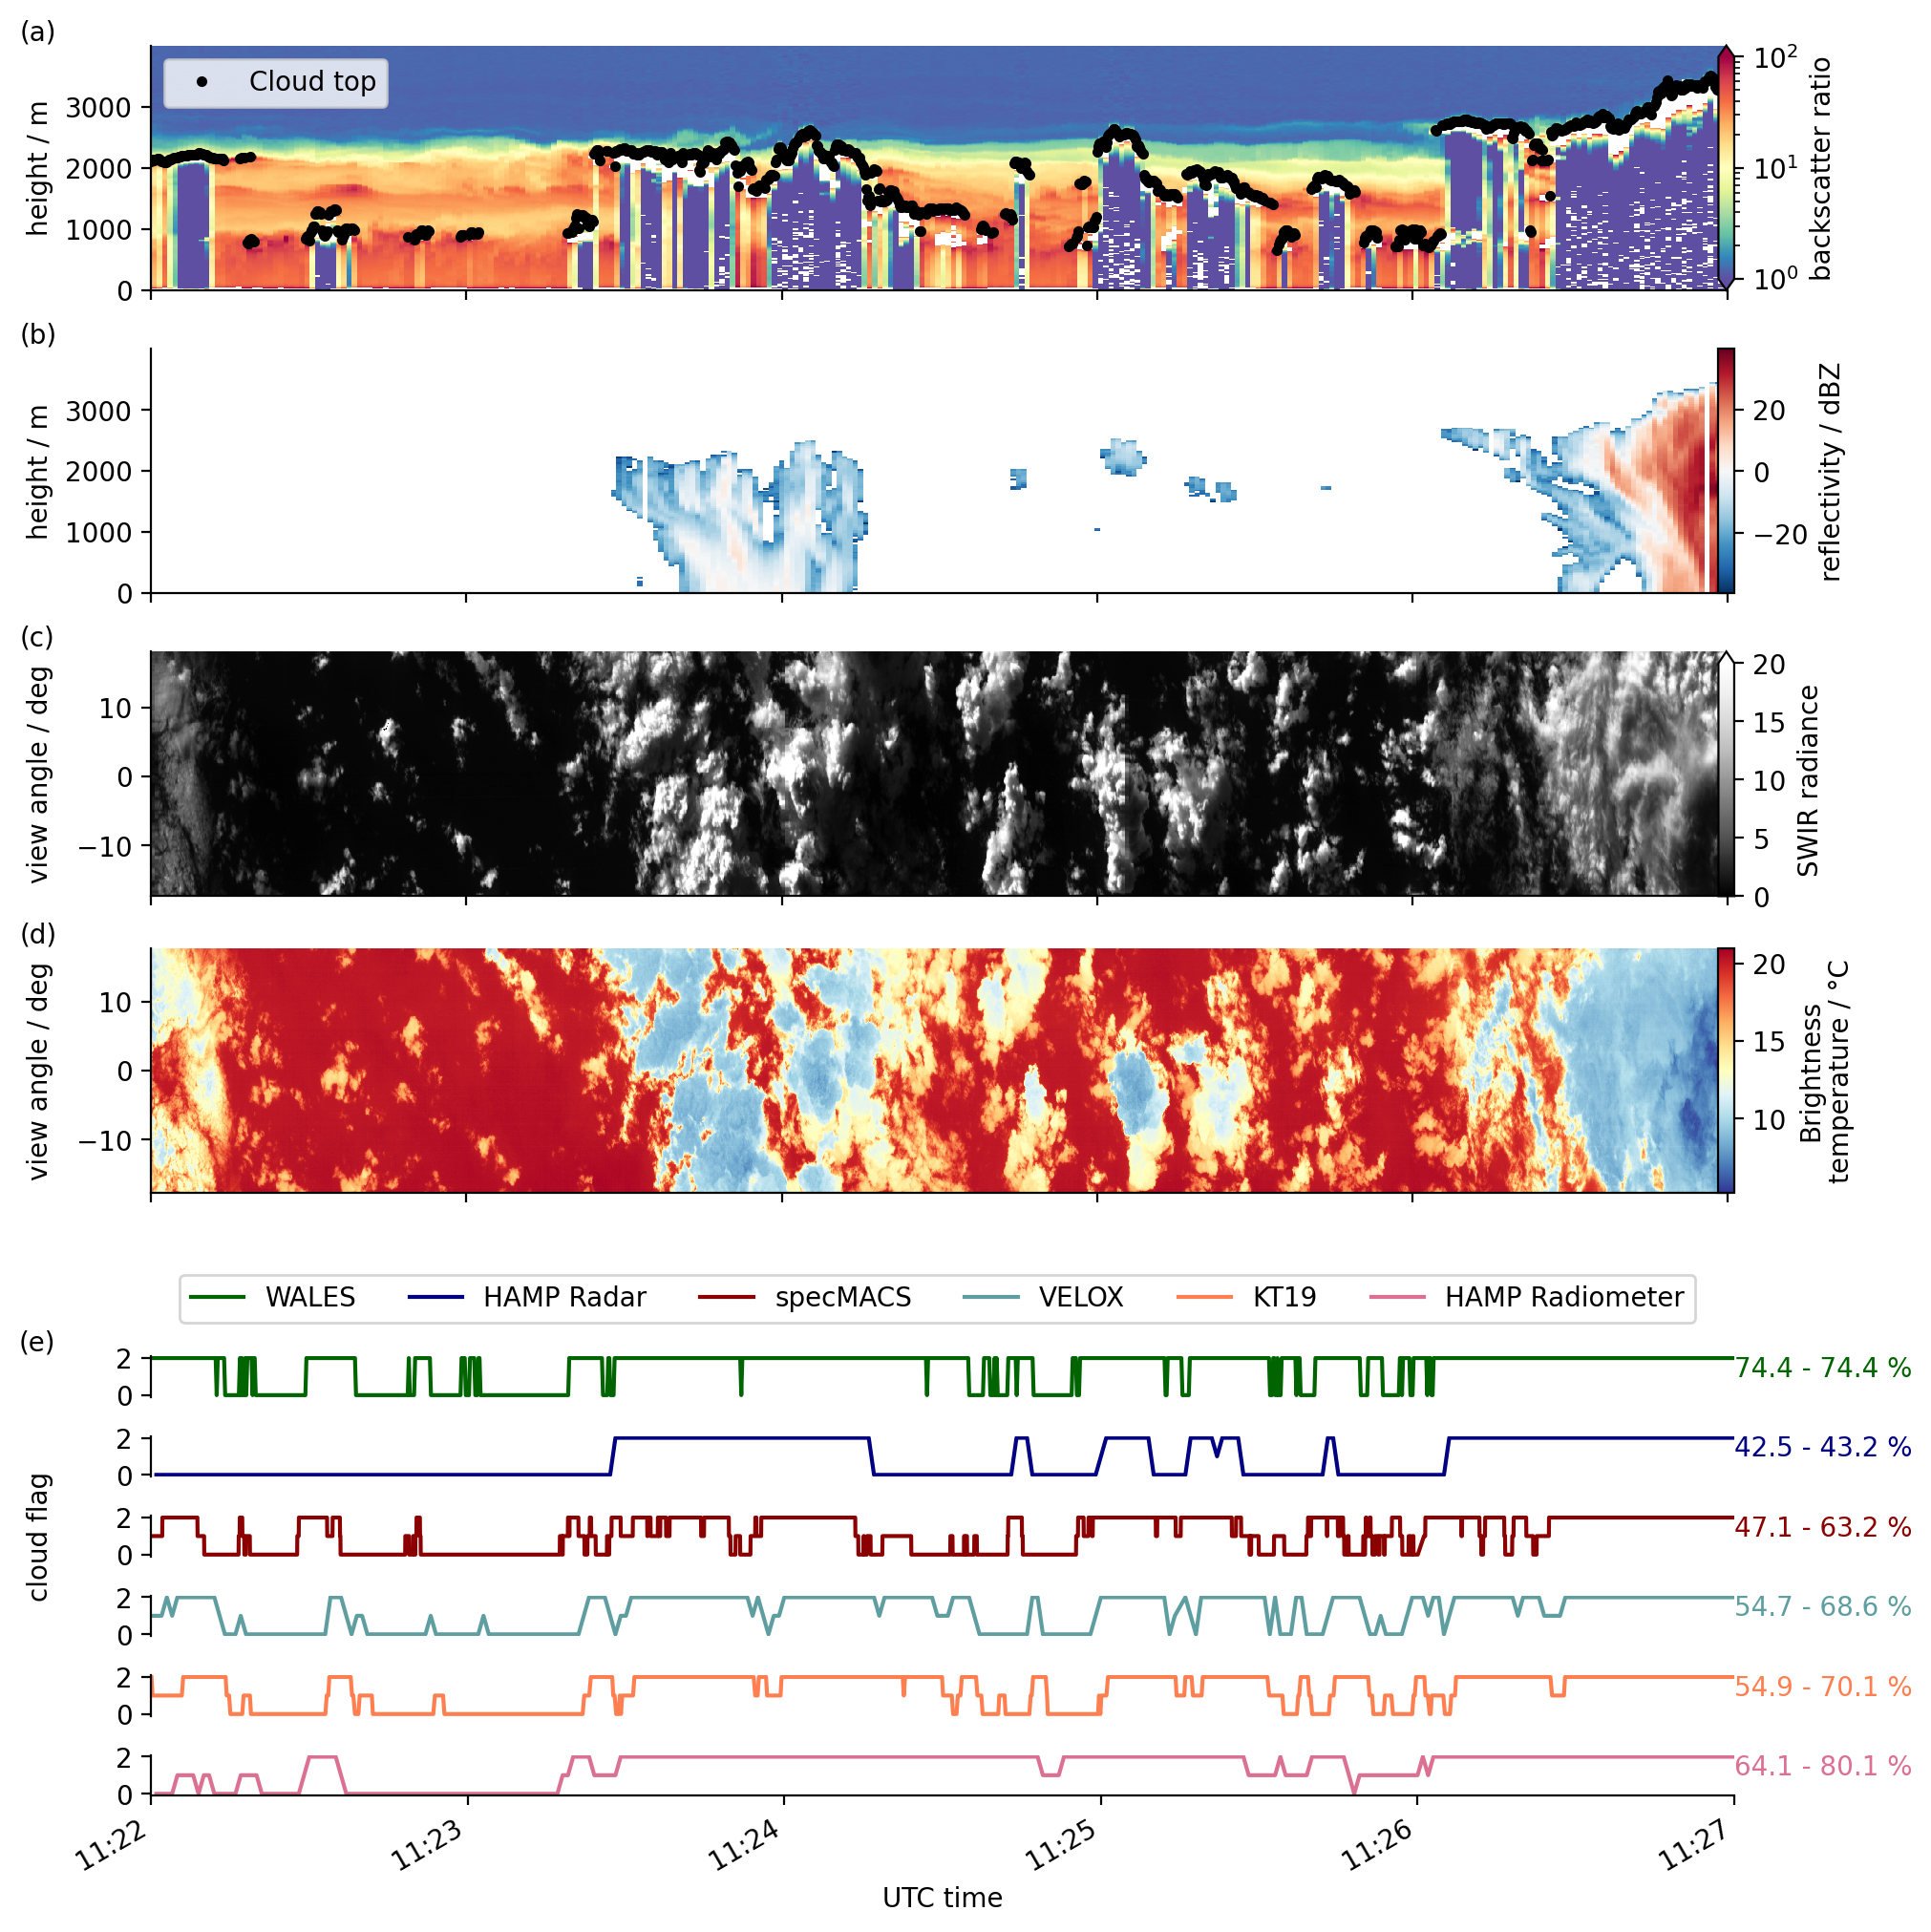

In [20]:
with plt.style.context("mplstyle/square"):
    fig, (ax0, ax1, ax2, ax3, axLegend, axL1, axL2, axL3, axL4, axL5, axL6) = plt.subplots(
        11, 1, sharex=True, gridspec_kw={"height_ratios": [3, 3, 3, 3, 0.5, 0.5, 0.5,
                                                           0.5, 0.5, 0.5, 0.5]}
    )

    ## 2D vertical
    # Wales backscatter ratio
    im0 = da_bsri.plot.pcolormesh(
        ax=ax0, x="time", y="height", norm=LogNorm(vmin=1, vmax=100),
        cmap="Spectral_r", rasterized=True, add_colorbar=False
    )
    cax0 = make_axes_locatable(ax0).append_axes("right", size="1%", pad=-0.05)
    fig.colorbar(im0, cax=cax0, label="backscatter ratio", extend='both')
    # cloud top height
    da_cth.plot(ax=ax0, x="time", ls="", marker=".", color="k", label="Cloud top")
    ax0.legend()

    # Radar reflectivity
    im1 = da_radar.plot(ax=ax1, x="time", rasterized=True, add_colorbar=False)
    cax1 = make_axes_locatable(ax1).append_axes("right", size="1%", pad=-0.05)
    fig.colorbar(im1, cax=cax1, label="reflectivity / dBZ")

    for ax in [ax0, ax1]:
        ax.set_yticks([0, 1000, 2000, 3000])
        ax.set_ylabel("height / m")

    ## 2D horizontal
    # SpecMACS radiance
    im2 = da_swir.plot.pcolormesh(ax=ax2, x="time", y="angle", cmap="Greys_r",
                                  vmin=0, vmax=20, rasterized=True, add_colorbar=False)
    cax2 = make_axes_locatable(ax2).append_axes("right", size="1%", pad=-0.05)
    fig.colorbar(im2, cax=cax2, label="SWIR radiance", extend='max')
    ax2.set_ylabel("view angle / deg")

    # VELOX brightness temperature
    im3 = (ds_bt.Brightness_temperature - 273.15).plot.pcolormesh(ax=ax3, x="time", y="va",
            cmap="RdYlBu_r", rasterized=True, add_colorbar=False)
    cax3 = make_axes_locatable(ax3).append_axes("right", size="1%", pad=-0.05)
    fig.colorbar(im3, cax=cax3, label="Brightness\ntemperature / °C")
    ax3.set_ylabel("view angle / deg")


    ## We leave an empty axis to put the legend here
    [s.set_visible(False) for s in axLegend.spines.values()]
    axLegend.xaxis.set_visible(False)
    axLegend.yaxis.set_visible(False)

    ## 1D
    # We plot 1D cloud masks
    # Each we annotate with a total min and max cloud cover for the scene shown and
    # remove disturbing spines
    lines = []
    plot_order = ['WALES', 'HAMP Radar', 'specMACS', 'VELOX', 'KT19', 'HAMP Radiometer']
    axes = dict(zip(plot_order, [axL1, axL2, axL3, axL4, axL5, axL6]))

    for k in plot_order:
        ds = data_feb5[k]
        lines += ds.cloud_mask.plot.line(ax=axes[k], x="time", label=k, color=colors[k])
        if axes[k]!=axL6:
            axes[k].spines["bottom"].set_visible(False)
            axes[k].xaxis.set_visible(False)
        axes[k].set_ylabel("")
        axes[k].annotate(f"{ds.CF_min.mean().values * 100:.1f}"
                         + f" - {ds.CF_max.mean().values * 100:.1f} %",
                         (1, 0.5), color=colors[k], xycoords="axes fraction")

    # We add one legend for all 1D cloud masks
    labels = [l.get_label() for l in lines]
    axL1.legend(lines, labels, ncol=7, bbox_to_anchor=(0.01, 1.5))
    axL3.set_ylabel("cloud flag")

    for ax in [ax0, ax1, ax2, ax3, axLegend, axL1, axL2, axL3, axL4, axL5, axL6]:
        ax.set_xlabel("")
        ax.set_title("")

    axL6.set_xlabel("UTC time")
    axL6.set_xticks(np.arange(np.datetime64('2020-02-05T11:22:00'),
                    np.datetime64('2020-02-05T11:28:00'), np.timedelta64(1, 'm')))
    ax0.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
    fig.autofmt_xdate()

    fig.align_ylabels(axs=[ax0, ax1, ax2, ax3, axL3])
    #fig.align_ylabels(axs=[cax0, cax1, cax2])

    label_pos_x = np.datetime64('2020-02-05T11:21:35')
    for ax, label in zip([ax0, ax1, ax2, ax3, axL1], ["(a)", "(b)", "(c)", "(d)", "(e)"]):
        ax.text(label_pos_x, ax.get_ylim()[1], label, verticalalignment='bottom')

## Statistical comparison

We will further compare cloud mask information from all HALO flights during EUREC⁴A on the basis of circle flight segments. Most of the time, the HALO aircraft sampled the airmass in circles east of Barbados. We use the meta data on flight segments, extract the information on start and end time of individual circles, and derive circle-average cloud cover.

For the 2D imagers VELOX and speMACS we use the full swath. In the case study above we had selected the central measurements for a better comparison with the other instruments. However, in the following we investigate the broad statistics and therefore include as much information on the cloud field as we can get from the full footprints of each instrument.

The following statistics are based on the **minimum cloud cover** including the cloud mask flag `most_likely_cloudy` and **maximum cloud cover** with cloud mask flags $\in$ {`most_likely_cloudy`, `probably_cloudy`}.

In [21]:
def midpoint(a, b):
    return a + (b - a) / 2

def cf_circles(ds):
    return xr.concat(
        [
            xr.Dataset({
                "CF_max": ds.sel(time=slice(i["start"], i["end"])).CF_max.mean(dim="time"),
                "CF_min": ds.sel(time=slice(i["start"], i["end"])).CF_min.mean(dim="time"),
                "time": xr.DataArray(midpoint(i["start"], i["end"]), dims=()),
                "segment_id": xr.DataArray(i["segment_id"], dims=())
            })
            for i in segments.values()
        ], dim="time")

### Get meta data

In [22]:
meta = eurec4a.get_flight_segments()

We extract all flight IDs of HALO's research flights

In [23]:
flight_ids = [flight_id
              for platform_id, flights in meta.items()
              if platform_id=="HALO"
              for flight_id, flight in flights.items()
              ]

Within each flight we further extract the circle segments

In [24]:
segments = {s["segment_id"]: {**s, "flight_id": flight["flight_id"]}
             for platform_id, flight_id in meta.items()
             if platform_id=="HALO"
             for flight in flight_id.values()
             for s in flight["segments"]
            if "circle" in s["kinds"]
            }
print(f"In total HALO flew {len(segments)} circles during EUREC4A")

In total HALO flew 72 circles during EUREC4A


### Time series of circle cloud cover
Time series of circle-mean (minimum) cloud cover estimates. The markers visualize the research-flight average, while the lines span the range of all circle-mean cloud cover estimates within a respective flight.

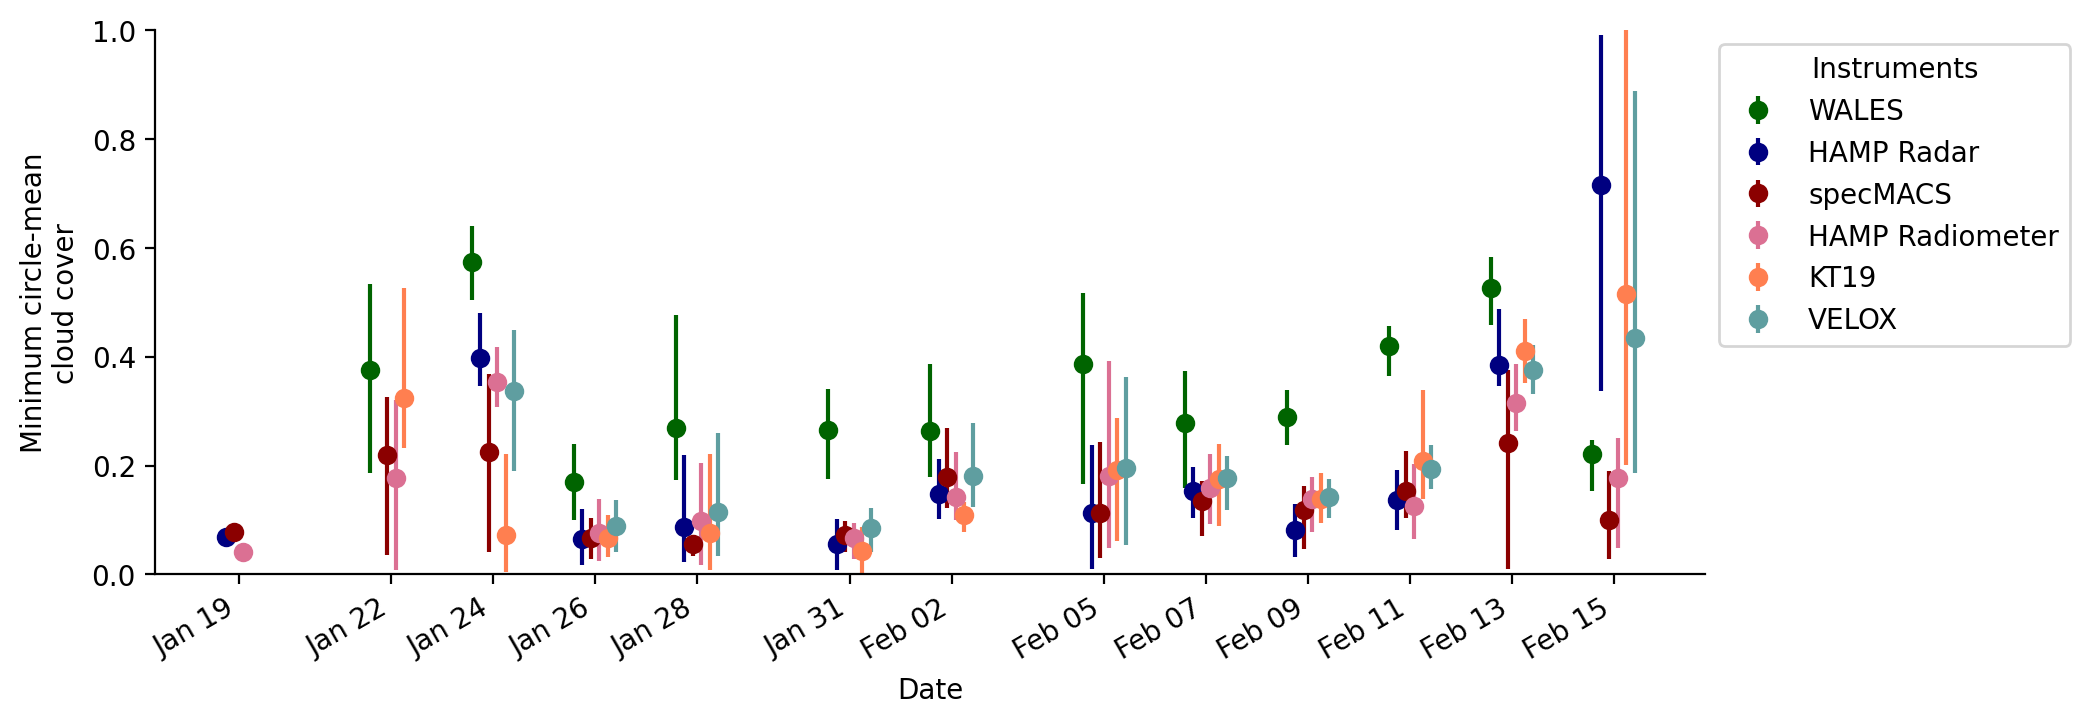

In [25]:
ts = np.timedelta64(2, 'h')

with plt.style.context("mplstyle/wide"):
    fig, ax = plt.subplots()
    for k, v in data.items():
        ds = cf_circles(v)
        ds["date"] = ds.time.astype('<M8[D]')
        ax.errorbar(
            x=np.unique(ds.date) + ts,
            y=ds.groupby("date").mean().CF_min.values,
            yerr=abs(np.array([ds.groupby("date").min().CF_min.values,
                               ds.groupby("date").max().CF_min.values])
                     - ds.groupby("date").mean().CF_min.values),
            fmt='o',
            color=colors[k],
            label=k,
        )
        ts += np.timedelta64(4, 'h')
    ax.set_ylim(0, 1)
    ax.set_xticks(np.unique(ds.date) + np.timedelta64(12, 'h'))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    fig.autofmt_xdate()

    ax.set_ylabel("Minimum circle-mean\ncloud cover")
    ax.legend(title="Instruments", bbox_to_anchor=(1,1), loc="upper left")
    ax.set_xlabel("Date")

### Histogram of circle-mean cloud cover

We first have a look at the distributions of circle-mean cloud cover based on the minimum (`most_likely_cloudy`) and the maximum estimates (`most_likely_cloudy` & `probably_cloudy`).

In [26]:
binedges = np.arange(0, 1.2, .2)
binmids = (binedges[1:] + binedges[:-1]) / 2

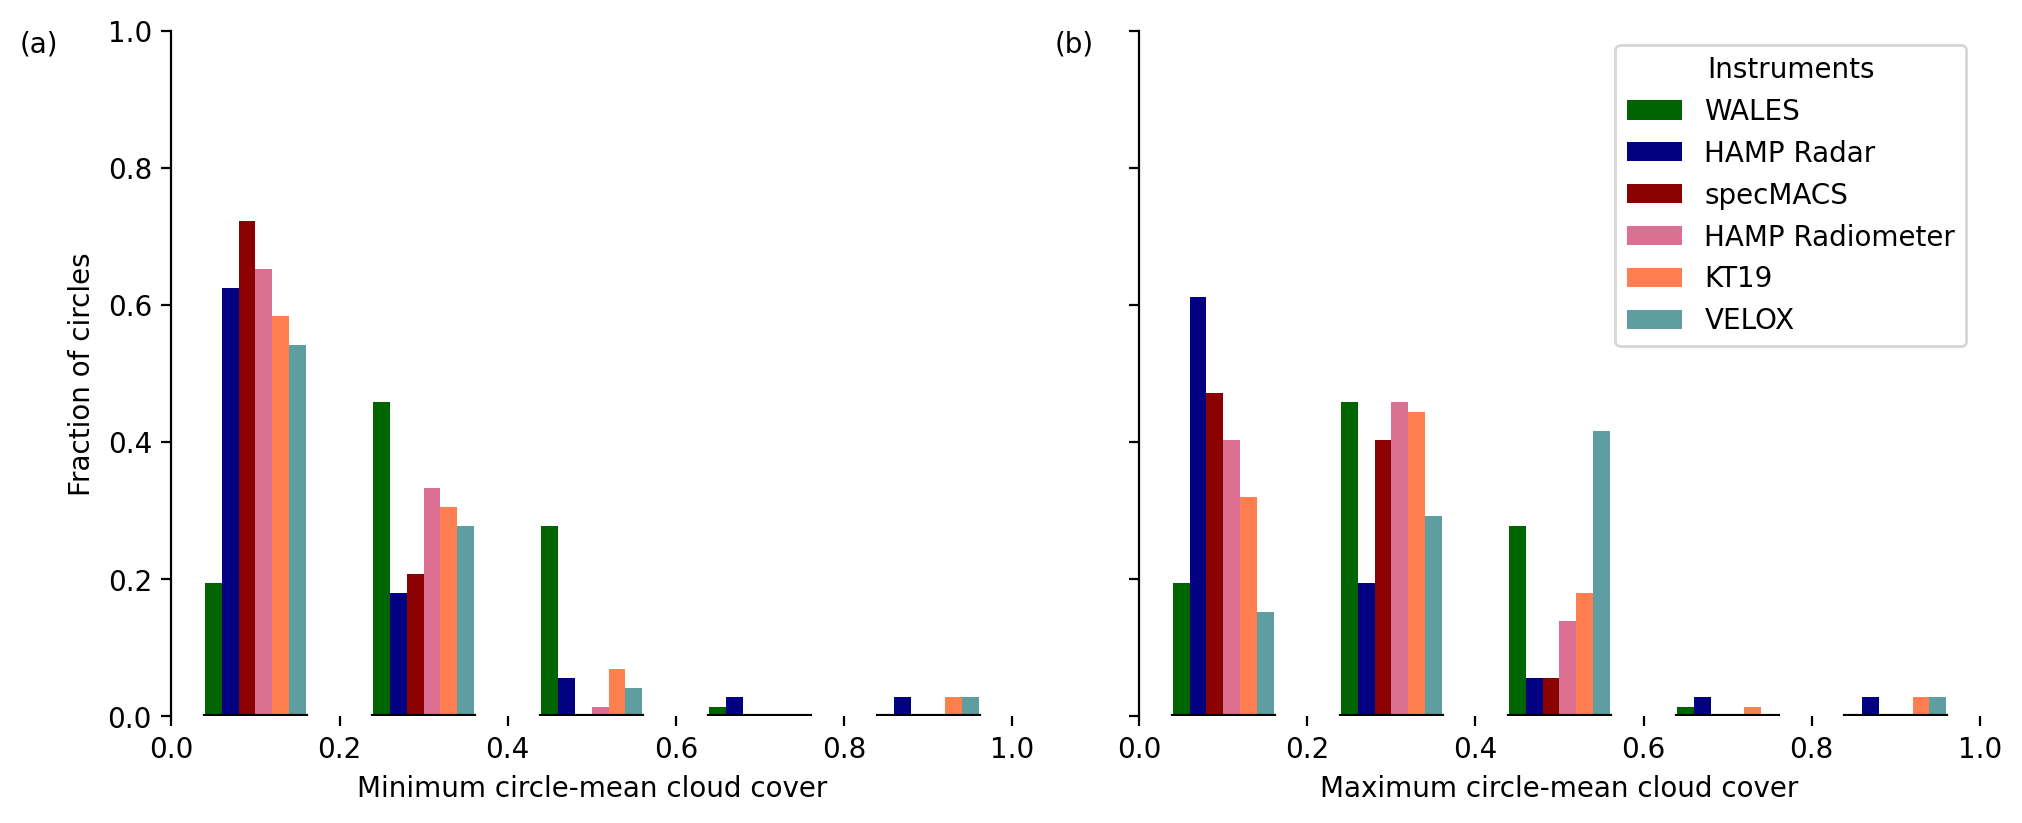

In [27]:
with plt.style.context("mplstyle/wide"):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
    count = 0
    width = 0.02
    for k, v in data.items():
        ds = cf_circles(v)
        ax0.bar(x=binmids - 0.05 + count,
                height=np.histogram(ds.CF_min.values, bins=binedges)[0] / ds.time.size,
                width=width, color=colors[k], label=k)
        ax1.bar(x=binmids - 0.05 + count,
                height=np.histogram(ds.CF_max.values, bins=binedges)[0] / ds.time.size,
                width=width, color=colors[k], label=k)
        count += 0.02

    xticks = [0.1, 0.3, 0.5, 0.7, 0.9]

    for ax in [ax0, ax1]:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.spines['bottom'].set_visible(False)
        for x in xticks:
            ax.axhline(y=0, xmin=x-0.06, xmax=x+0.06, color="k")
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])


    ax0.set_xlabel("Minimum circle-mean cloud cover")
    ax1.set_xlabel("Maximum circle-mean cloud cover")
    ax0.set_ylabel("Fraction of circles")
    ax1.legend(title="Instruments", bbox_to_anchor=(.55,1), loc="upper left")

    ax0.text(-0.18, ax.get_ylim()[1], "(a)", verticalalignment='top')
    ax1.text(-0.1, ax.get_ylim()[1], "(b)", verticalalignment='top')

For a better comparison of minimum and maximum circle-mean cloud cover we merge the two above plots and show their difference in the following plot. In particular, we show the cumulative fraction of circle-mean cloud cover estimates. Depending on the instruments and some instrument downtimes, the available circle counts range from 64 to 72. The bins on the x-axis have a bin width of 0.2 respectively. The bars span the range defined by the minimum cloud cover based on cloud flag `most likely cloudy`and the maximum cloud cover based on cloud flags `most likely cloudy` and `probably cloudy`.

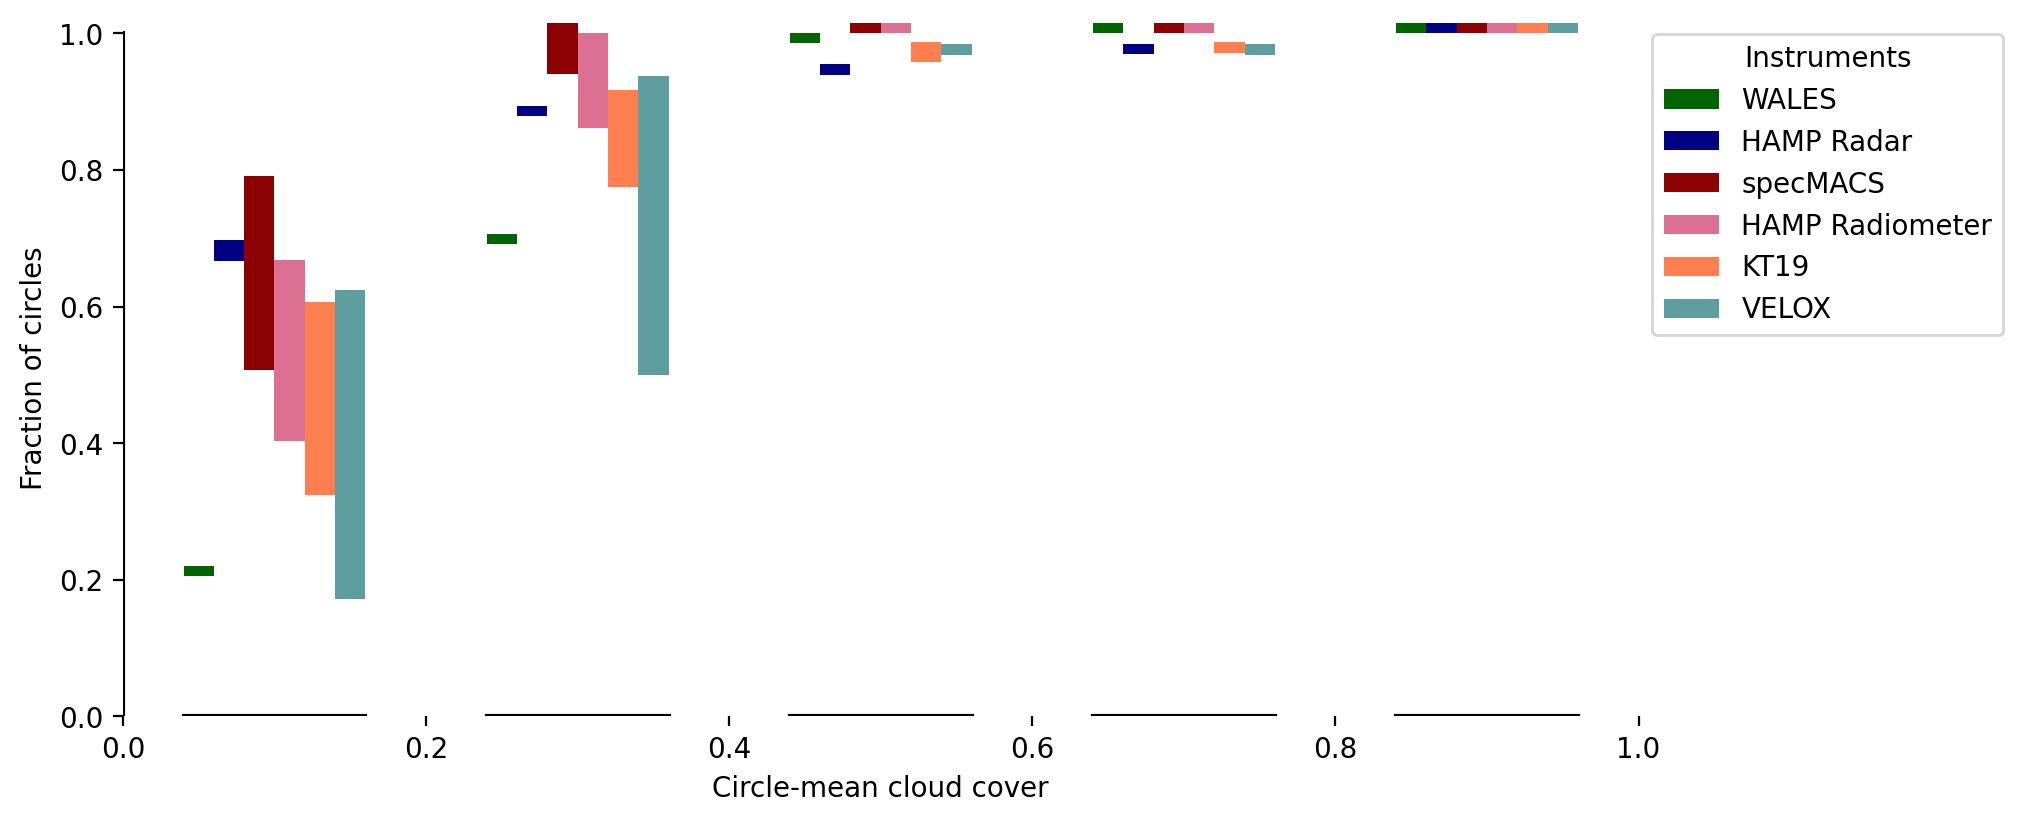

In [28]:
with plt.style.context("mplstyle/wide"):
    fig, ax = plt.subplots()
    count = 0
    width = 0.02
    for k, v in data.items():
        ds = cf_circles(v)
        hist_min = (np.histogram(ds.CF_min.values, bins=binedges)[0]
                    / (ds.time.size - np.isnan(ds.CF_min.values).sum()))
        hist_max = (np.histogram(ds.CF_max.values, bins=binedges)[0]
                    / (ds.time.size - np.isnan(ds.CF_max.values).sum()))
        # draw a fake default line at the minimum
        ax.bar(x=binmids - 0.05 + count,
                height=0.015,
                width=width,
                bottom=np.cumsum(hist_min),
                color=colors[k], label=k)
        ax.bar(x=binmids - 0.05 + count,
                height=np.cumsum(hist_max) - np.cumsum(hist_min),
                width=width,
                bottom=np.cumsum(hist_min),
                color=colors[k])
        count+=0.02

    # manually set x- and y-axis
    [s.set_visible(False) for s in ax.spines.values()]
    # x-axis
    ax.set_xlim(0, 1)
    xticks = [0.1, 0.3, 0.5, 0.7, 0.9]
    for x in xticks:
        ax.axhline(y=0, xmin=x-0.06, xmax=x+0.06, color="k")
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xlabel("Circle-mean cloud cover")
    # y-axis
    ax.set_ylim(0, 1.02)
    ax.plot([0, 0], [0, 1], color="k")
    ax.set_ylabel("Fraction of circles")

    ax.legend(title="Instruments", bbox_to_anchor=(1,1), loc="upper left")

### A small interpretation attempt
We highlight a few features that stick out in the above figures showing the cloud cover statistics.

Time series:
* the WALES dataset does not have a `probably_cloudy` flag, and thus, the `CF_min` and `CF_max` variables are the same. The instrument design and methodology used to define the cloud flag seems to be very sensitive to small and optically thin clouds and the cloud cover estimates agree better with the `CF_max` of all other instruments.
* The time series shows that on the transfer flight on 19 January the HAMP radar and radiometer and specMACS datasets were processed and datasets are available including one circle near Barbados. For WALES, VELOX, and KT19 no data is available.
* The disagreement in cloud cover estimates for the flight on 15 February is partly due to a deep stratocumulus layer with a strong reflection at cloud top that blinded the lidar (WALES), while the radar was still able to provide reasonable estimates.

Distributions:
* All instruments, excluding WALES, agree well in the distribution of circle-mean cloud cover estimates according to their `CF_min` variable, while they vary on their definition of uncertain `probably_cloudy` measurements that are included in `CF_max`.
* In the case of VELOX as well as for all other passive instruments, the cloud cover estimates shift to higher numbers when including the uncertain cloud flag (from minimum to maximum cloud cover).
* The fraction of circle-mean cloud cover difference (minimum to maximum) shows a disagreement between the instruments for cloud cover ranges up to about 0.5 due to their different detection principles. Optically thin clouds can have a significant impact on circle-mean estimates in low cloud cover situations and lead to uncertain pixels. WALES can detect such thin clouds and suggest generally higher cloud cover with the change in cumulative fraction being strongest between 0.2 and 0.6.
* In general we find that only few circles have a cloud cover higher than 0.6. At such high cloud cover the instruments agree remarkably well and also, minimum and maximum cloud cover are almost equal.
* About 50 % of the time cloud cover estimates are below 0.2.

## Camapign mean cloud cover
* from all available data including the transfer flights

In [29]:
print("Instrument: min - max")
print("")
for k, v in data.items():
    print(f"{k}: {v.CF_min.mean().values:.2f} - {v.CF_max.mean().values:.2f} ")

Instrument: min - max

WALES: 0.34 - 0.34 
HAMP Radar: 0.25 - 0.25 


specMACS: 0.18 - 0.24 
HAMP Radiometer: 0.17 - 0.25 
KT19: 0.20 - 0.31 
VELOX: 0.21 - 0.39 


* only from local research flights

In [30]:
localRF = slice("2020-01-22T00:00:00", "2020-02-15T23:59:59")

In [31]:
print("Instrument: min - max")
print("")
for k, v in data.items():
    print(f"{k}: {v.sel(time=localRF).CF_min.mean().values:.2f} - "
          + f"{v.sel(time=localRF).CF_max.mean().values:.2f} ")

Instrument: min - max

WALES: 0.34 - 0.34 
HAMP Radar: 0.21 - 0.22 


specMACS: 0.16 - 0.22 
HAMP Radiometer: 0.16 - 0.25 
KT19: 0.20 - 0.31 
VELOX: 0.21 - 0.39 
